In [1]:
import sys
sys.path.append('../../src')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline

import visualization.visualize as vis
import models.evaluation as ev

In [2]:
filename = '../../data/raw/Myocardial infarction complications Database.csv'
data = pd.read_csv(filename)
data

,ID,AGE,SEX,INF_ANAM,STENOK_AN,FK_STENOK,IBS_POST,IBS_NASL,GB,SIM_GIPERT,...,JELUD_TAH,FIBR_JELUD,A_V_BLOK,OTEK_LANC,RAZRIV,DRESSLER,ZSN,REC_IM,P_IM_STEN,LET_IS
0,1,77.0,1,2.0,1.0,1.0,2.0,NaN,3.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,2,55.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,3,52.0,1,0.0,0.0,0.0,2.0,NaN,2.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,4,68.0,0,0.0,0.0,0.0,2.0,NaN,2.0,0.0,...,0,0,0,0,0,0,1,0,0,0
4,5,60.0,1,0.0,0.0,0.0,2.0,NaN,3.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1695,1696,77.0,0,0.0,4.0,2.0,1.0,NaN,2.0,0.0,...,0,0,1,0,1,0,0,0,0,3
1696,1697,70.0,0,0.0,6.0,2.0,1.0,NaN,2.0,0.0,...,0,0,0,0,0,0,0,0,0,1
1697,1698,55.0,1,3.0,6.0,2.0,2.0,NaN,0.0,0.0,...,0,0,0,0,0,0,0,1,0,6
1698,1699,79.0,0,2.0,2.0,2.0,1.0,NaN,2.0,0.0,...,0,0,0,1,0,0,0,0,0,1


# Data Preparation

In [3]:
ID_COLS = ['ID']
TARGET_COLS = ['FIBR_PREDS', 'PREDS_TAH', 'JELUD_TAH', 'FIBR_JELUD', 'A_V_BLOK',
               'OTEK_LANC', 'RAZRIV', 'DRESSLER', 'ZSN', 'REC_IM', 'P_IM_STEN', 'LET_IS']
TARGET_COL = 'LET_IS'

In [4]:
data_train, data_test = train_test_split(data, test_size=0.3, random_state=42)

print('data_train:', data_train.shape)
print('data_test:', data_test.shape)

data_train: (1190, 124)
data_test: (510, 124)


In [5]:
def data_preparation(x_df, y_cols, target_col):
    x_array = x_df.drop(columns=y_cols)
    y_true = x_df[target_col].values   
    
    return x_array, y_true

x_train, y_train = data_preparation(data_train, TARGET_COLS+ID_COLS, TARGET_COL)
x_test, y_test = data_preparation(data_test, TARGET_COLS+ID_COLS, TARGET_COL)

In [6]:
x_train

,AGE,SEX,INF_ANAM,STENOK_AN,FK_STENOK,IBS_POST,IBS_NASL,GB,SIM_GIPERT,DLIT_AG,...,NOT_NA_1_n,NOT_NA_2_n,NOT_NA_3_n,LID_S_n,B_BLOK_S_n,ANT_CA_S_n,GEPAR_S_n,ASP_S_n,TIKL_S_n,TRENT_S_n
1133,48.0,1,2.0,6.0,2.0,1.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
900,59.0,0,0.0,6.0,2.0,1.0,NaN,2.0,0.0,6.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
682,78.0,0,1.0,4.0,2.0,2.0,NaN,2.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
767,64.0,1,0.0,2.0,2.0,2.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
177,68.0,0,0.0,5.0,2.0,2.0,NaN,2.0,0.0,5.0,...,2.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,73.0,1,0.0,3.0,2.0,2.0,NaN,2.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1294,63.0,1,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
860,58.0,1,2.0,4.0,2.0,2.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1459,64.0,0,1.0,1.0,2.0,2.0,NaN,2.0,0.0,6.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0


In [7]:
y_train

array([0, 0, 0, ..., 0, 4, 0], dtype=int64)

In [8]:
x_test

,AGE,SEX,INF_ANAM,STENOK_AN,FK_STENOK,IBS_POST,IBS_NASL,GB,SIM_GIPERT,DLIT_AG,...,NOT_NA_1_n,NOT_NA_2_n,NOT_NA_3_n,LID_S_n,B_BLOK_S_n,ANT_CA_S_n,GEPAR_S_n,ASP_S_n,TIKL_S_n,TRENT_S_n
1492,67.0,0,1.0,0.0,0.0,2.0,NaN,2.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
115,59.0,0,0.0,0.0,0.0,0.0,NaN,2.0,0.0,6.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
135,58.0,1,0.0,0.0,0.0,2.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
352,61.0,1,0.0,0.0,0.0,2.0,NaN,2.0,0.0,7.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
1302,77.0,0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1228,62.0,1,0.0,4.0,2.0,1.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
471,43.0,1,1.0,0.0,0.0,2.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
322,69.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
1235,80.0,0,0.0,0.0,0.0,2.0,NaN,2.0,0.0,6.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0


In [9]:
y_test

array([4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 4, 0, 0, 4, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 3, 1, 0, 0, 3, 0, 0, 0,
       6, 0, 0, 0, 1, 0, 0, 0, 0, 5, 0, 1, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0,
       0, 0, 3, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       4, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 7, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0,
       0, 0, 5, 0, 0, 0, 4, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 3, 0, 0, 0, 0, 0, 7, 4, 0, 0, 1, 0, 0, 0, 0, 0, 0, 4, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 3, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0,

# Pre-processing

In [10]:
feature_cols = np.array(x_train.columns[~np.isin(x_train.columns, ID_COLS+TARGET_COLS)])
feature_cols

array(['AGE', 'SEX', 'INF_ANAM', 'STENOK_AN', 'FK_STENOK', 'IBS_POST',
       'IBS_NASL', 'GB', 'SIM_GIPERT', 'DLIT_AG', 'ZSN_A', 'nr_11',
       'nr_01', 'nr_02', 'nr_03', 'nr_04', 'nr_07', 'nr_08', 'np_01',
       'np_04', 'np_05', 'np_07', 'np_08', 'np_09', 'np_10', 'endocr_01',
       'endocr_02', 'endocr_03', 'zab_leg_01', 'zab_leg_02', 'zab_leg_03',
       'zab_leg_04', 'zab_leg_06', 'S_AD_KBRIG', 'D_AD_KBRIG',
       'S_AD_ORIT', 'D_AD_ORIT', 'O_L_POST', 'K_SH_POST', 'MP_TP_POST',
       'SVT_POST', 'GT_POST', 'FIB_G_POST', 'ant_im', 'lat_im', 'inf_im',
       'post_im', 'IM_PG_P', 'ritm_ecg_p_01', 'ritm_ecg_p_02',
       'ritm_ecg_p_04', 'ritm_ecg_p_06', 'ritm_ecg_p_07', 'ritm_ecg_p_08',
       'n_r_ecg_p_01', 'n_r_ecg_p_02', 'n_r_ecg_p_03', 'n_r_ecg_p_04',
       'n_r_ecg_p_05', 'n_r_ecg_p_06', 'n_r_ecg_p_08', 'n_r_ecg_p_09',
       'n_r_ecg_p_10', 'n_p_ecg_p_01', 'n_p_ecg_p_03', 'n_p_ecg_p_04',
       'n_p_ecg_p_05', 'n_p_ecg_p_06', 'n_p_ecg_p_07', 'n_p_ecg_p_08',
       'n_p

In [11]:
# Data cleaning:
features_cleaner = ColumnTransformer([
                        ("features cleaning", SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=-1), feature_cols),
                        ])


In [12]:
# Pre-processing pipeline:
preprocessor = Pipeline([('data cleaning', features_cleaner),
                         ])



In [13]:
x_train_encoded = preprocessor.fit_transform(x_train)
x_train_encoded

array([[48.,  1.,  2., ...,  1.,  0.,  0.],
       [59.,  0.,  0., ...,  0.,  0.,  0.],
       [78.,  0.,  1., ...,  1.,  0.,  0.],
       ...,
       [58.,  1.,  2., ...,  0.,  1.,  0.],
       [64.,  0.,  1., ...,  0.,  0.,  1.],
       [78.,  0.,  2., ...,  1.,  0.,  0.]])

In [14]:
x_test_encoded = preprocessor.transform(x_test)
x_test_encoded

array([[67.,  0.,  1., ...,  0.,  0.,  0.],
       [59.,  0.,  0., ...,  1.,  0.,  0.],
       [58.,  1.,  0., ...,  1.,  0.,  0.],
       ...,
       [69.,  1.,  0., ...,  1.,  0.,  0.],
       [80.,  0.,  0., ...,  1.,  0.,  0.],
       [63.,  1.,  1., ...,  0.,  0.,  1.]])

# Plottting Embeddings:

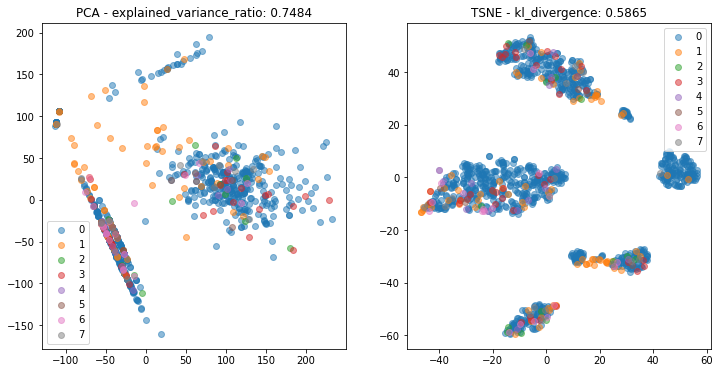

In [15]:
vis.plot_embeddings(x_train_encoded, y_train)

# Training a basic model

In [16]:
n_jobs = 4

In [17]:
# Create the parameter grid based on the results of random search 
param_grid = {'bootstrap': [False, True],
              'max_depth': [80, 90, 100, 110],
              'max_features': [2, 3],
              'min_samples_leaf': [3, 4, 5],
              'min_samples_split': [8, 10, 12],
              'n_estimators': [100, 200, 300, 1000]}


rf = RandomForestClassifier()
clf = RandomizedSearchCV(rf, param_distributions=param_grid, n_iter=50,
                         scoring='balanced_accuracy', n_jobs=n_jobs, verbose=1)

clf.fit(x_train_encoded, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(estimator=RandomForestClassifier(), n_iter=50, n_jobs=4,
                   param_distributions={'bootstrap': [False, True],
                                        'max_depth': [80, 90, 100, 110],
                                        'max_features': [2, 3],
                                        'min_samples_leaf': [3, 4, 5],
                                        'min_samples_split': [8, 10, 12],
                                        'n_estimators': [100, 200, 300, 1000]},
                   scoring='balanced_accuracy', verbose=1)

In [18]:
rf_clf = clf.best_estimator_
rf_clf.fit(x_train_encoded, y_train)

RandomForestClassifier(bootstrap=False, max_depth=90, max_features=3,
                       min_samples_leaf=4, min_samples_split=8,
                       n_estimators=200)

# Evaluating the model:

c:\users\weldl\miniconda3\envs\work\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classes evaluated: ['0', '1', '2', '3', '4', '5', '6', '7']
Correctly classified......: 449/510
Accuracy (simple) ........: 0.88
Balanced acc.  ...........: 0.21
Balanced acc. (adjusted)..: 0.10
Acc. norm (Recall avgs) ..: 0.21
Precision = tp / (tp + fp): [0.89 0.77 0.   0.   0.   0.   0.   0.  ] -> accuracy of positive predictions
Recall    = tp / (tp + fn): [1.   0.68 0.   0.   0.   0.   0.   0.  ] -> sensibility (true positive rate)
F1 score .................: [0.94 0.72 0.   0.   0.   0.   0.   0.  ] -> harmonic mean


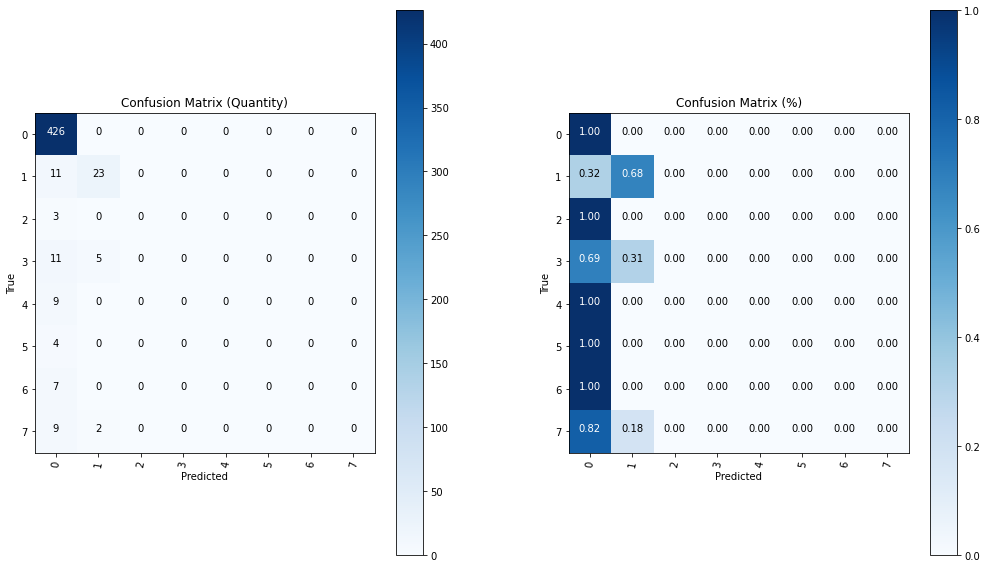

In [19]:
y_pred = rf_clf.predict(x_test_encoded)
test_metrics = ev.performance_measures(y_test, y_pred)

c:\users\weldl\miniconda3\envs\work\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\weldl\miniconda3\envs\work\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\weldl\miniconda3\envs\work\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


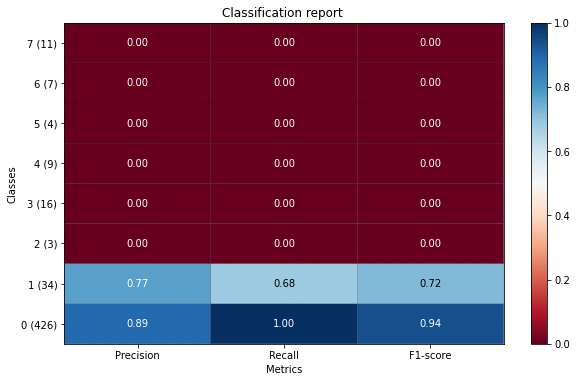

In [20]:
ev.plot_classification_report(y_test, y_pred)